# Подключение всего нужного

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random
from torch.autograd import Variable

# Работа с данными

In [3]:
# Гиперпараметры
batch_size = 128
img_size = (64, 64)
max_images = 128000  # Количество загружаемых изображений

In [4]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [5]:
def load_images_from_folder(folder, max_images=max_images):
    images = []
    file_paths = [os.path.join(folder, filename) for filename in os.listdir(folder)]
    
    for i, file_path in enumerate(file_paths):
        if i >= max_images:
            break
        try:
            with Image.open(file_path) as img:
                img = img.convert('RGB')
                images.append(img)
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    
    return images

In [6]:
def transform_images_to_tensors(images):
    tensors = [transform(img) for img in images]
    return tensors

In [7]:
folder_path = 'D:\\ML\\dstasets\\img_align_celeba\\img_align_celeba'
images = load_images_from_folder(folder_path)

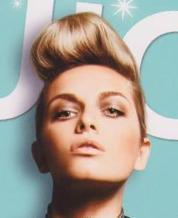

In [8]:
images[3]

In [9]:
image_tensors = transform_images_to_tensors(images)

In [10]:
image_tensors[0]

tensor([[[-0.4824, -0.4745, -0.4275,  ..., -0.3725, -0.4196, -0.3725],
         [-0.4902, -0.4824, -0.4353,  ..., -0.3725, -0.4196, -0.3647],
         [-0.5137, -0.5059, -0.4431,  ..., -0.3804, -0.4196, -0.3569],
         ...,
         [-0.3176, -0.0196,  0.3333,  ...,  0.0588,  0.1451,  0.2627],
         [ 0.4431,  0.5765,  0.5765,  ..., -0.0824,  0.0275,  0.1451],
         [ 0.7255,  0.6706,  0.4980,  ..., -0.1216,  0.0196,  0.0902]],

        [[-0.6000, -0.6000, -0.5608,  ..., -0.4039, -0.4510, -0.3961],
         [-0.5922, -0.6000, -0.5608,  ..., -0.4039, -0.4510, -0.3882],
         [-0.6000, -0.6000, -0.5529,  ..., -0.4118, -0.4510, -0.3804],
         ...,
         [-0.2706,  0.0118,  0.3647,  ..., -0.2078, -0.0118,  0.2000],
         [ 0.4588,  0.5843,  0.5843,  ..., -0.3961, -0.2157,  0.0039],
         [ 0.7176,  0.6627,  0.4980,  ..., -0.4745, -0.2863, -0.1137]],

        [[-0.6471, -0.6549, -0.6235,  ..., -0.4275, -0.4745, -0.4353],
         [-0.6392, -0.6471, -0.6157,  ..., -0

In [11]:
image_tensors[0].size()

torch.Size([3, 64, 64])

In [12]:
dataloader = DataLoader(image_tensors, batch_size=batch_size, shuffle=False)

In [13]:
len(dataloader)

1000

In [14]:
images = next(iter(dataloader))

In [15]:
images.size()

torch.Size([128, 3, 64, 64])

# Инициализация генератора и дискриминатора

In [16]:
# Параметры
latent_dim = 100
output_dim = 3 * 64 * 64
hidden_dim = 128

In [17]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
# Инициализация генератора и дискриминатора
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# Create the generator
netG = Generator().to(device)

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [37]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [38]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Дополнительные действия

In [39]:
# Определение оптимизаторов и функции потерь
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [40]:
# Функция для отображения сгенерированных изображений
def generate_and_show(generator, latent_dim, num_images=1):
    z_vec = torch.randn(num_images, latent_dim, 1, 1).to(device)
    generated_images = generator(z_vec).cpu().detach()
    grid = vutils.make_grid(generated_images, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Generated Images')
    plt.axis('off')
    plt.show()

# Обучение всей сети

Starting Training Loop...
[0/100][0/1000]	Loss_D: 1.8116	Loss_G: 4.7107	D(x): 0.5000	D(G(z)): 0.5481 / 0.0152


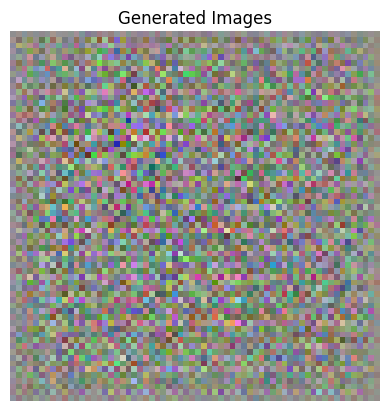

[0/100][50/1000]	Loss_D: 0.0176	Loss_G: 37.1318	D(x): 0.9850	D(G(z)): 0.0000 / 0.0000
[0/100][100/1000]	Loss_D: 0.0953	Loss_G: 10.3373	D(x): 0.9518	D(G(z)): 0.0002 / 0.0002
[0/100][150/1000]	Loss_D: 0.4167	Loss_G: 6.3160	D(x): 0.7945	D(G(z)): 0.0084 / 0.0049
[0/100][200/1000]	Loss_D: 0.4797	Loss_G: 3.8288	D(x): 0.7610	D(G(z)): 0.0669 / 0.0365
[0/100][250/1000]	Loss_D: 0.6222	Loss_G: 4.3704	D(x): 0.7744	D(G(z)): 0.2367 / 0.0227
[0/100][300/1000]	Loss_D: 0.6581	Loss_G: 5.6722	D(x): 0.9058	D(G(z)): 0.3712 / 0.0061
[0/100][350/1000]	Loss_D: 2.5297	Loss_G: 3.7410	D(x): 0.2095	D(G(z)): 0.0045 / 0.0559
[0/100][400/1000]	Loss_D: 0.5176	Loss_G: 2.9649	D(x): 0.7155	D(G(z)): 0.0789 / 0.0878
[0/100][450/1000]	Loss_D: 0.4203	Loss_G: 3.4920	D(x): 0.9330	D(G(z)): 0.2371 / 0.0601
[0/100][500/1000]	Loss_D: 0.6079	Loss_G: 4.3990	D(x): 0.8068	D(G(z)): 0.2553 / 0.0233


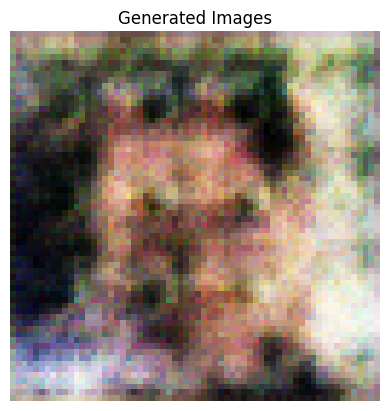

[0/100][550/1000]	Loss_D: 0.5667	Loss_G: 4.1292	D(x): 0.7772	D(G(z)): 0.1993 / 0.0283
[0/100][600/1000]	Loss_D: 0.5045	Loss_G: 3.5317	D(x): 0.7665	D(G(z)): 0.0956 / 0.0456
[0/100][650/1000]	Loss_D: 0.4192	Loss_G: 6.4335	D(x): 0.7360	D(G(z)): 0.0207 / 0.0052
[0/100][700/1000]	Loss_D: 0.4839	Loss_G: 4.0145	D(x): 0.8145	D(G(z)): 0.1639 / 0.0301
[0/100][750/1000]	Loss_D: 1.0405	Loss_G: 2.0650	D(x): 0.5100	D(G(z)): 0.0318 / 0.2487
[0/100][800/1000]	Loss_D: 0.5399	Loss_G: 4.9006	D(x): 0.8853	D(G(z)): 0.3002 / 0.0129
[0/100][850/1000]	Loss_D: 0.4914	Loss_G: 4.5414	D(x): 0.8213	D(G(z)): 0.1902 / 0.0192
[0/100][900/1000]	Loss_D: 0.8150	Loss_G: 2.7714	D(x): 0.5834	D(G(z)): 0.0460 / 0.1168
[0/100][950/1000]	Loss_D: 0.4082	Loss_G: 3.6067	D(x): 0.8024	D(G(z)): 0.0983 / 0.0556
[1/100][0/1000]	Loss_D: 0.4177	Loss_G: 2.9437	D(x): 0.8078	D(G(z)): 0.1071 / 0.0837


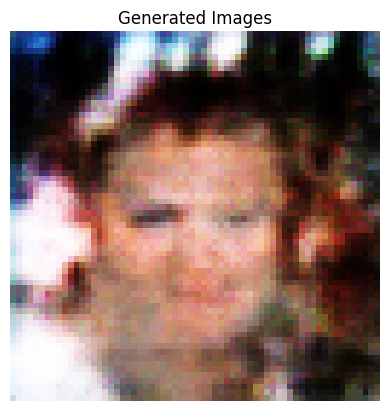

[1/100][50/1000]	Loss_D: 0.4884	Loss_G: 3.4157	D(x): 0.7769	D(G(z)): 0.1424 / 0.0545
[1/100][100/1000]	Loss_D: 0.3505	Loss_G: 6.2608	D(x): 0.9594	D(G(z)): 0.2211 / 0.0069
[1/100][150/1000]	Loss_D: 0.3548	Loss_G: 3.5401	D(x): 0.7961	D(G(z)): 0.0682 / 0.0656
[1/100][200/1000]	Loss_D: 0.4972	Loss_G: 2.9005	D(x): 0.7694	D(G(z)): 0.1049 / 0.0858
[1/100][250/1000]	Loss_D: 0.7316	Loss_G: 3.0233	D(x): 0.7419	D(G(z)): 0.2166 / 0.0772
[1/100][300/1000]	Loss_D: 0.3681	Loss_G: 4.2820	D(x): 0.8740	D(G(z)): 0.1746 / 0.0224
[1/100][350/1000]	Loss_D: 0.3096	Loss_G: 2.7016	D(x): 0.9370	D(G(z)): 0.1512 / 0.1297
[1/100][400/1000]	Loss_D: 0.5561	Loss_G: 2.4470	D(x): 0.7158	D(G(z)): 0.1071 / 0.1491
[1/100][450/1000]	Loss_D: 0.5003	Loss_G: 4.9366	D(x): 0.9001	D(G(z)): 0.2829 / 0.0129
[1/100][500/1000]	Loss_D: 0.5791	Loss_G: 5.5136	D(x): 0.9437	D(G(z)): 0.3515 / 0.0109


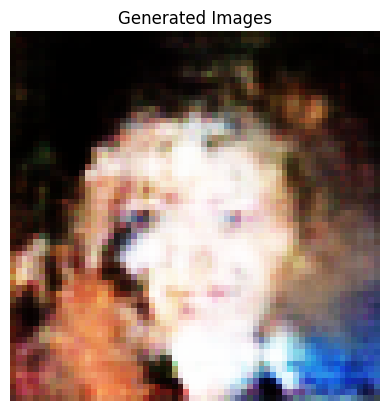

[1/100][550/1000]	Loss_D: 1.2658	Loss_G: 7.8047	D(x): 0.8896	D(G(z)): 0.5796 / 0.0019
[1/100][600/1000]	Loss_D: 0.3321	Loss_G: 3.4518	D(x): 0.8584	D(G(z)): 0.1266 / 0.0595
[1/100][650/1000]	Loss_D: 0.7333	Loss_G: 1.3361	D(x): 0.5867	D(G(z)): 0.0443 / 0.3468
[1/100][700/1000]	Loss_D: 0.4378	Loss_G: 4.3412	D(x): 0.8480	D(G(z)): 0.1830 / 0.0246
[1/100][750/1000]	Loss_D: 2.5165	Loss_G: 1.8736	D(x): 0.1653	D(G(z)): 0.0090 / 0.2722
[1/100][800/1000]	Loss_D: 0.3513	Loss_G: 3.2655	D(x): 0.8808	D(G(z)): 0.1729 / 0.0527
[1/100][850/1000]	Loss_D: 0.9861	Loss_G: 2.4447	D(x): 0.4803	D(G(z)): 0.0081 / 0.1563
[1/100][900/1000]	Loss_D: 0.3711	Loss_G: 3.4304	D(x): 0.8161	D(G(z)): 0.1239 / 0.0520
[1/100][950/1000]	Loss_D: 0.4106	Loss_G: 4.5536	D(x): 0.8849	D(G(z)): 0.2150 / 0.0179
[2/100][0/1000]	Loss_D: 0.3679	Loss_G: 3.7646	D(x): 0.8572	D(G(z)): 0.1554 / 0.0407


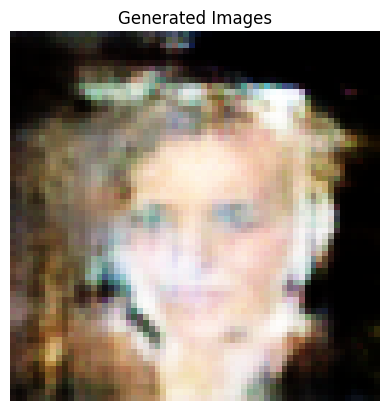

[2/100][50/1000]	Loss_D: 0.4404	Loss_G: 3.7616	D(x): 0.8681	D(G(z)): 0.2183 / 0.0362
[2/100][100/1000]	Loss_D: 2.6161	Loss_G: 1.6722	D(x): 0.1465	D(G(z)): 0.0016 / 0.2804
[2/100][150/1000]	Loss_D: 0.4245	Loss_G: 2.7170	D(x): 0.7322	D(G(z)): 0.0458 / 0.1113
[2/100][200/1000]	Loss_D: 0.3695	Loss_G: 3.2984	D(x): 0.7879	D(G(z)): 0.0777 / 0.0584
[2/100][250/1000]	Loss_D: 0.3050	Loss_G: 3.7721	D(x): 0.8690	D(G(z)): 0.1175 / 0.0400
[2/100][300/1000]	Loss_D: 0.5883	Loss_G: 2.6659	D(x): 0.7577	D(G(z)): 0.2165 / 0.0903
[2/100][350/1000]	Loss_D: 2.1235	Loss_G: 8.5767	D(x): 0.9716	D(G(z)): 0.8245 / 0.0006
[2/100][400/1000]	Loss_D: 0.4678	Loss_G: 3.9930	D(x): 0.8941	D(G(z)): 0.2638 / 0.0295
[2/100][450/1000]	Loss_D: 0.4251	Loss_G: 2.4839	D(x): 0.7603	D(G(z)): 0.0960 / 0.1110
[2/100][500/1000]	Loss_D: 0.4707	Loss_G: 4.4757	D(x): 0.9096	D(G(z)): 0.2731 / 0.0196


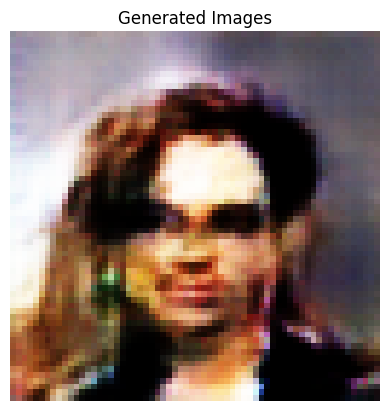

[2/100][550/1000]	Loss_D: 0.6168	Loss_G: 2.8710	D(x): 0.7499	D(G(z)): 0.2083 / 0.0937
[2/100][600/1000]	Loss_D: 0.3321	Loss_G: 3.3456	D(x): 0.9041	D(G(z)): 0.1868 / 0.0490
[2/100][650/1000]	Loss_D: 0.6443	Loss_G: 1.9084	D(x): 0.6980	D(G(z)): 0.1757 / 0.1967
[2/100][700/1000]	Loss_D: 0.4489	Loss_G: 3.2114	D(x): 0.8350	D(G(z)): 0.2013 / 0.0637
[2/100][750/1000]	Loss_D: 0.4232	Loss_G: 3.5664	D(x): 0.8457	D(G(z)): 0.1876 / 0.0436
[2/100][800/1000]	Loss_D: 0.6124	Loss_G: 2.7821	D(x): 0.7478	D(G(z)): 0.2301 / 0.0842
[2/100][850/1000]	Loss_D: 1.1719	Loss_G: 0.6537	D(x): 0.3978	D(G(z)): 0.0394 / 0.5941
[2/100][900/1000]	Loss_D: 0.7767	Loss_G: 1.3648	D(x): 0.5817	D(G(z)): 0.1224 / 0.3151
[2/100][950/1000]	Loss_D: 0.5329	Loss_G: 4.2574	D(x): 0.9176	D(G(z)): 0.3211 / 0.0231
[3/100][0/1000]	Loss_D: 0.5040	Loss_G: 3.3531	D(x): 0.8320	D(G(z)): 0.2381 / 0.0535


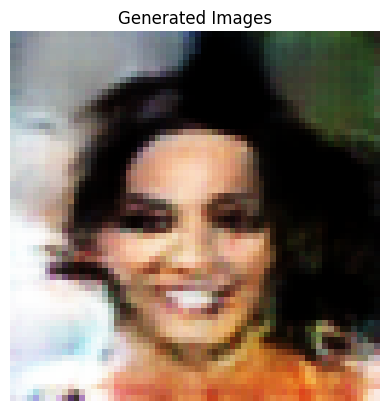

[3/100][50/1000]	Loss_D: 1.0997	Loss_G: 2.9850	D(x): 0.6986	D(G(z)): 0.3947 / 0.1326
[3/100][100/1000]	Loss_D: 0.3748	Loss_G: 3.1163	D(x): 0.8667	D(G(z)): 0.1796 / 0.0630
[3/100][150/1000]	Loss_D: 1.3315	Loss_G: 4.6745	D(x): 0.9634	D(G(z)): 0.6697 / 0.0192
[3/100][200/1000]	Loss_D: 0.8690	Loss_G: 4.8255	D(x): 0.9142	D(G(z)): 0.4851 / 0.0122
[3/100][250/1000]	Loss_D: 2.3670	Loss_G: 0.9125	D(x): 0.1651	D(G(z)): 0.0180 / 0.4839
[3/100][300/1000]	Loss_D: 0.7689	Loss_G: 4.4607	D(x): 0.8855	D(G(z)): 0.4335 / 0.0172
[3/100][350/1000]	Loss_D: 1.0901	Loss_G: 6.1211	D(x): 0.9390	D(G(z)): 0.5925 / 0.0038
[3/100][400/1000]	Loss_D: 0.5420	Loss_G: 2.3162	D(x): 0.7167	D(G(z)): 0.1403 / 0.1409
[3/100][450/1000]	Loss_D: 0.5880	Loss_G: 3.2616	D(x): 0.8541	D(G(z)): 0.3098 / 0.0560
[3/100][500/1000]	Loss_D: 0.6436	Loss_G: 2.7686	D(x): 0.7740	D(G(z)): 0.2670 / 0.0845


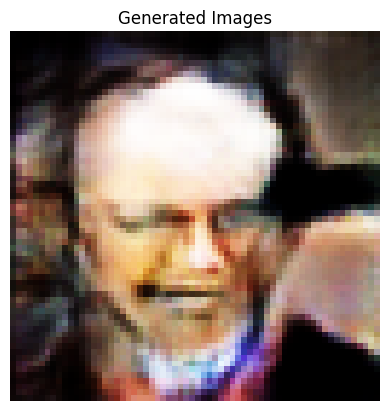

[3/100][550/1000]	Loss_D: 0.6757	Loss_G: 2.3244	D(x): 0.7346	D(G(z)): 0.2385 / 0.1346
[3/100][600/1000]	Loss_D: 0.6993	Loss_G: 1.5723	D(x): 0.6317	D(G(z)): 0.1269 / 0.2487
[3/100][650/1000]	Loss_D: 0.5512	Loss_G: 2.2961	D(x): 0.7358	D(G(z)): 0.1704 / 0.1328
[3/100][700/1000]	Loss_D: 0.5245	Loss_G: 1.8638	D(x): 0.7007	D(G(z)): 0.1140 / 0.1961
[3/100][750/1000]	Loss_D: 0.4781	Loss_G: 2.2378	D(x): 0.7220	D(G(z)): 0.1049 / 0.1346
[3/100][800/1000]	Loss_D: 0.5361	Loss_G: 2.2879	D(x): 0.7967	D(G(z)): 0.2346 / 0.1377
[3/100][850/1000]	Loss_D: 0.6049	Loss_G: 1.9047	D(x): 0.7092	D(G(z)): 0.1748 / 0.1990
[3/100][900/1000]	Loss_D: 0.5105	Loss_G: 2.4172	D(x): 0.8347	D(G(z)): 0.2519 / 0.1136
[3/100][950/1000]	Loss_D: 0.6504	Loss_G: 1.4682	D(x): 0.6053	D(G(z)): 0.0715 / 0.2860
[4/100][0/1000]	Loss_D: 0.6708	Loss_G: 3.4557	D(x): 0.8431	D(G(z)): 0.3475 / 0.0443


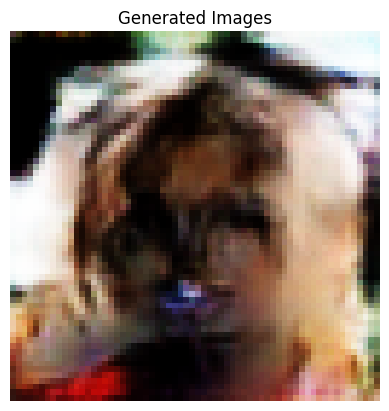

[4/100][50/1000]	Loss_D: 0.8755	Loss_G: 3.2234	D(x): 0.9094	D(G(z)): 0.4904 / 0.0632
[4/100][100/1000]	Loss_D: 0.8146	Loss_G: 1.0001	D(x): 0.5189	D(G(z)): 0.0489 / 0.4265
[4/100][150/1000]	Loss_D: 0.8352	Loss_G: 4.1826	D(x): 0.8988	D(G(z)): 0.4672 / 0.0219
[4/100][200/1000]	Loss_D: 0.7226	Loss_G: 4.3465	D(x): 0.8909	D(G(z)): 0.4067 / 0.0190
[4/100][250/1000]	Loss_D: 0.3822	Loss_G: 2.4319	D(x): 0.8622	D(G(z)): 0.1843 / 0.1187
[4/100][300/1000]	Loss_D: 1.2956	Loss_G: 1.0445	D(x): 0.4030	D(G(z)): 0.1338 / 0.4143
[4/100][350/1000]	Loss_D: 0.6547	Loss_G: 3.1229	D(x): 0.8972	D(G(z)): 0.3871 / 0.0583
[4/100][400/1000]	Loss_D: 0.5393	Loss_G: 1.8230	D(x): 0.7038	D(G(z)): 0.1311 / 0.2032
[4/100][450/1000]	Loss_D: 0.5797	Loss_G: 1.5930	D(x): 0.6741	D(G(z)): 0.1144 / 0.2487
[4/100][500/1000]	Loss_D: 0.5942	Loss_G: 2.6752	D(x): 0.7737	D(G(z)): 0.2520 / 0.0867


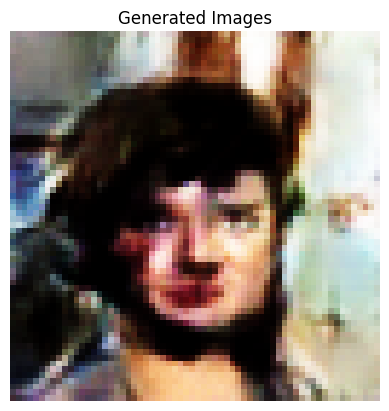

[4/100][550/1000]	Loss_D: 2.1535	Loss_G: 5.5606	D(x): 0.9745	D(G(z)): 0.8441 / 0.0065
[4/100][600/1000]	Loss_D: 0.7528	Loss_G: 2.9438	D(x): 0.8065	D(G(z)): 0.3674 / 0.0721
[4/100][650/1000]	Loss_D: 0.5014	Loss_G: 1.9554	D(x): 0.7346	D(G(z)): 0.1482 / 0.1779
[4/100][700/1000]	Loss_D: 0.5107	Loss_G: 2.7819	D(x): 0.8349	D(G(z)): 0.2556 / 0.0788
[4/100][750/1000]	Loss_D: 0.6160	Loss_G: 3.2855	D(x): 0.7782	D(G(z)): 0.2629 / 0.0531
[4/100][800/1000]	Loss_D: 1.2577	Loss_G: 2.0976	D(x): 0.6617	D(G(z)): 0.4957 / 0.1569
[4/100][850/1000]	Loss_D: 0.5858	Loss_G: 1.8587	D(x): 0.7217	D(G(z)): 0.1836 / 0.2100
[4/100][900/1000]	Loss_D: 0.5666	Loss_G: 1.3362	D(x): 0.7094	D(G(z)): 0.1477 / 0.3051
[4/100][950/1000]	Loss_D: 0.8091	Loss_G: 1.3395	D(x): 0.5330	D(G(z)): 0.0614 / 0.3091
[5/100][0/1000]	Loss_D: 0.5815	Loss_G: 2.3702	D(x): 0.7360	D(G(z)): 0.2038 / 0.1180


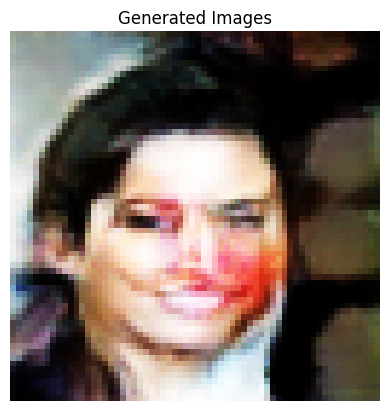

[5/100][50/1000]	Loss_D: 0.6565	Loss_G: 3.7313	D(x): 0.8733	D(G(z)): 0.3653 / 0.0337
[5/100][100/1000]	Loss_D: 0.5024	Loss_G: 2.7362	D(x): 0.7223	D(G(z)): 0.1226 / 0.0970
[5/100][150/1000]	Loss_D: 0.5117	Loss_G: 3.0104	D(x): 0.8825	D(G(z)): 0.2909 / 0.0677
[5/100][200/1000]	Loss_D: 0.4533	Loss_G: 2.8188	D(x): 0.8904	D(G(z)): 0.2532 / 0.0867
[5/100][250/1000]	Loss_D: 0.5333	Loss_G: 2.3366	D(x): 0.8326	D(G(z)): 0.2658 / 0.1188
[5/100][300/1000]	Loss_D: 1.9637	Loss_G: 0.1496	D(x): 0.1926	D(G(z)): 0.0172 / 0.8786
[5/100][350/1000]	Loss_D: 0.6857	Loss_G: 3.4937	D(x): 0.9046	D(G(z)): 0.4033 / 0.0421
[5/100][400/1000]	Loss_D: 0.8022	Loss_G: 1.9172	D(x): 0.6818	D(G(z)): 0.2777 / 0.1888
[5/100][450/1000]	Loss_D: 0.4914	Loss_G: 2.6093	D(x): 0.8292	D(G(z)): 0.2292 / 0.0957
[5/100][500/1000]	Loss_D: 0.5121	Loss_G: 2.3230	D(x): 0.7987	D(G(z)): 0.2256 / 0.1248


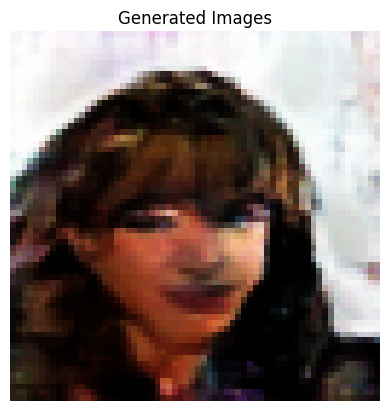

[5/100][550/1000]	Loss_D: 0.9120	Loss_G: 4.1309	D(x): 0.8654	D(G(z)): 0.4882 / 0.0229
[5/100][600/1000]	Loss_D: 0.7061	Loss_G: 2.0320	D(x): 0.6878	D(G(z)): 0.2345 / 0.1640
[5/100][650/1000]	Loss_D: 0.7102	Loss_G: 3.0404	D(x): 0.8822	D(G(z)): 0.4044 / 0.0606
[5/100][700/1000]	Loss_D: 0.5281	Loss_G: 3.5724	D(x): 0.9005	D(G(z)): 0.3148 / 0.0386
[5/100][750/1000]	Loss_D: 1.3787	Loss_G: 0.7424	D(x): 0.3522	D(G(z)): 0.0720 / 0.5155
[5/100][800/1000]	Loss_D: 0.7526	Loss_G: 3.2471	D(x): 0.8644	D(G(z)): 0.3965 / 0.0520
[5/100][850/1000]	Loss_D: 1.3919	Loss_G: 0.6651	D(x): 0.3313	D(G(z)): 0.0496 / 0.5653
[5/100][900/1000]	Loss_D: 0.7818	Loss_G: 1.0762	D(x): 0.5676	D(G(z)): 0.0958 / 0.3990
[5/100][950/1000]	Loss_D: 0.5754	Loss_G: 1.7609	D(x): 0.7294	D(G(z)): 0.1818 / 0.2121
[6/100][0/1000]	Loss_D: 0.4580	Loss_G: 2.7192	D(x): 0.7929	D(G(z)): 0.1763 / 0.0822


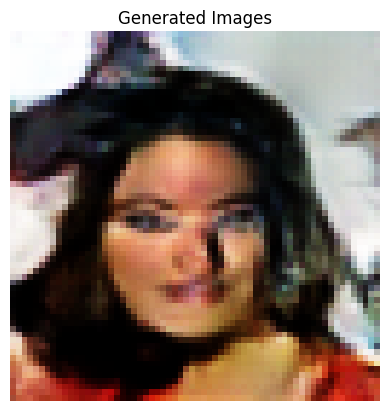

[6/100][50/1000]	Loss_D: 0.7319	Loss_G: 3.5968	D(x): 0.9075	D(G(z)): 0.4368 / 0.0371
[6/100][100/1000]	Loss_D: 0.6693	Loss_G: 1.4984	D(x): 0.6073	D(G(z)): 0.0909 / 0.2874
[6/100][150/1000]	Loss_D: 0.5552	Loss_G: 2.2045	D(x): 0.7869	D(G(z)): 0.2385 / 0.1364
[6/100][200/1000]	Loss_D: 0.5824	Loss_G: 1.5189	D(x): 0.6906	D(G(z)): 0.1356 / 0.2655
[6/100][250/1000]	Loss_D: 0.6673	Loss_G: 1.6168	D(x): 0.6284	D(G(z)): 0.1196 / 0.2388
[6/100][300/1000]	Loss_D: 0.5124	Loss_G: 2.6049	D(x): 0.7697	D(G(z)): 0.1943 / 0.0952
[6/100][350/1000]	Loss_D: 0.4312	Loss_G: 2.9859	D(x): 0.8651	D(G(z)): 0.2215 / 0.0716
[6/100][400/1000]	Loss_D: 0.5177	Loss_G: 2.3182	D(x): 0.7508	D(G(z)): 0.1715 / 0.1341
[6/100][450/1000]	Loss_D: 0.5791	Loss_G: 2.3669	D(x): 0.7538	D(G(z)): 0.2185 / 0.1260
[6/100][500/1000]	Loss_D: 0.5256	Loss_G: 2.4412	D(x): 0.7236	D(G(z)): 0.1470 / 0.1122


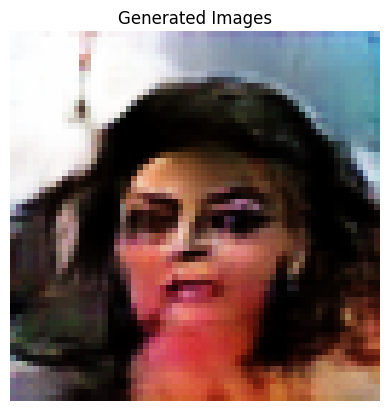

[6/100][550/1000]	Loss_D: 0.4162	Loss_G: 2.5732	D(x): 0.8124	D(G(z)): 0.1686 / 0.0946
[6/100][600/1000]	Loss_D: 0.8210	Loss_G: 1.9396	D(x): 0.6441	D(G(z)): 0.2492 / 0.1819
[6/100][650/1000]	Loss_D: 0.5786	Loss_G: 2.4737	D(x): 0.7782	D(G(z)): 0.2445 / 0.1051
[6/100][700/1000]	Loss_D: 0.6081	Loss_G: 2.1059	D(x): 0.7165	D(G(z)): 0.1901 / 0.1448
[6/100][750/1000]	Loss_D: 0.9992	Loss_G: 3.9774	D(x): 0.8045	D(G(z)): 0.4866 / 0.0308
[6/100][800/1000]	Loss_D: 0.4674	Loss_G: 1.7991	D(x): 0.7651	D(G(z)): 0.1465 / 0.2050
[6/100][850/1000]	Loss_D: 0.8237	Loss_G: 1.2218	D(x): 0.5470	D(G(z)): 0.1069 / 0.3454
[6/100][900/1000]	Loss_D: 0.5379	Loss_G: 2.0458	D(x): 0.7857	D(G(z)): 0.2232 / 0.1743
[6/100][950/1000]	Loss_D: 0.4593	Loss_G: 2.0906	D(x): 0.7916	D(G(z)): 0.1790 / 0.1504
[7/100][0/1000]	Loss_D: 0.4148	Loss_G: 2.6443	D(x): 0.8046	D(G(z)): 0.1505 / 0.0930


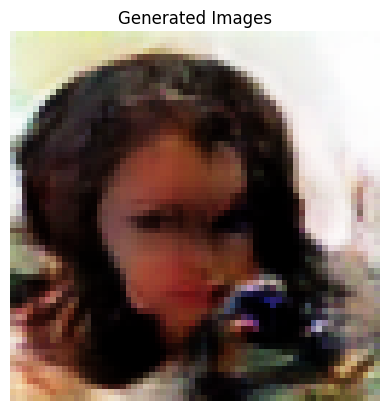

[7/100][50/1000]	Loss_D: 0.5142	Loss_G: 2.8497	D(x): 0.8480	D(G(z)): 0.2586 / 0.0790
[7/100][100/1000]	Loss_D: 0.5346	Loss_G: 3.7518	D(x): 0.8713	D(G(z)): 0.2956 / 0.0327
[7/100][150/1000]	Loss_D: 0.5039	Loss_G: 2.5107	D(x): 0.7682	D(G(z)): 0.1731 / 0.1100
[7/100][200/1000]	Loss_D: 0.6609	Loss_G: 1.6965	D(x): 0.6262	D(G(z)): 0.1101 / 0.2176
[7/100][250/1000]	Loss_D: 0.5412	Loss_G: 1.9660	D(x): 0.7088	D(G(z)): 0.1399 / 0.1842
[7/100][300/1000]	Loss_D: 0.5220	Loss_G: 3.2659	D(x): 0.8731	D(G(z)): 0.2925 / 0.0499
[7/100][350/1000]	Loss_D: 1.3287	Loss_G: 5.9583	D(x): 0.8339	D(G(z)): 0.6157 / 0.0056
[7/100][400/1000]	Loss_D: 0.5004	Loss_G: 3.4041	D(x): 0.9187	D(G(z)): 0.3123 / 0.0437
[7/100][450/1000]	Loss_D: 0.6477	Loss_G: 3.8586	D(x): 0.9079	D(G(z)): 0.3883 / 0.0268
[7/100][500/1000]	Loss_D: 0.7436	Loss_G: 3.7581	D(x): 0.7991	D(G(z)): 0.3502 / 0.0337


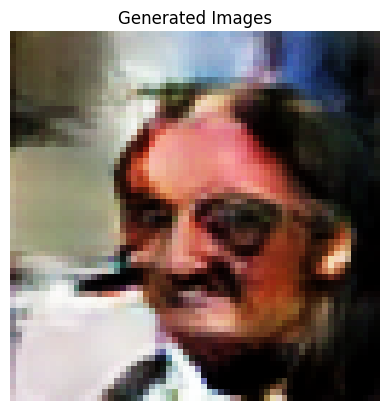

[7/100][550/1000]	Loss_D: 0.4686	Loss_G: 2.1360	D(x): 0.7788	D(G(z)): 0.1701 / 0.1548
[7/100][600/1000]	Loss_D: 0.6145	Loss_G: 1.6016	D(x): 0.6559	D(G(z)): 0.1172 / 0.2524
[7/100][650/1000]	Loss_D: 0.6877	Loss_G: 3.4386	D(x): 0.9165	D(G(z)): 0.4091 / 0.0462
[7/100][700/1000]	Loss_D: 0.7710	Loss_G: 4.0744	D(x): 0.9168	D(G(z)): 0.4456 / 0.0250
[7/100][750/1000]	Loss_D: 0.5286	Loss_G: 2.5416	D(x): 0.8538	D(G(z)): 0.2776 / 0.0965
[7/100][800/1000]	Loss_D: 0.5015	Loss_G: 3.6354	D(x): 0.9161	D(G(z)): 0.3103 / 0.0340
[7/100][850/1000]	Loss_D: 0.5206	Loss_G: 2.9757	D(x): 0.8277	D(G(z)): 0.2451 / 0.0713
[7/100][900/1000]	Loss_D: 0.5908	Loss_G: 3.2972	D(x): 0.8837	D(G(z)): 0.3339 / 0.0523
[7/100][950/1000]	Loss_D: 0.6794	Loss_G: 1.3384	D(x): 0.6148	D(G(z)): 0.0948 / 0.3375
[8/100][0/1000]	Loss_D: 0.5079	Loss_G: 2.7184	D(x): 0.7839	D(G(z)): 0.1996 / 0.0846


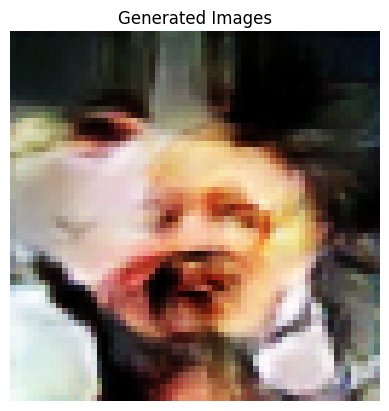

[8/100][50/1000]	Loss_D: 0.4383	Loss_G: 1.8036	D(x): 0.7576	D(G(z)): 0.1197 / 0.1996
[8/100][100/1000]	Loss_D: 0.6299	Loss_G: 2.2039	D(x): 0.5991	D(G(z)): 0.0417 / 0.1516
[8/100][150/1000]	Loss_D: 0.6725	Loss_G: 2.3804	D(x): 0.7491	D(G(z)): 0.2710 / 0.1224
[8/100][200/1000]	Loss_D: 0.3963	Loss_G: 2.7324	D(x): 0.8141	D(G(z)): 0.1478 / 0.0865
[8/100][250/1000]	Loss_D: 0.4541	Loss_G: 2.0057	D(x): 0.7908	D(G(z)): 0.1701 / 0.1663
[8/100][300/1000]	Loss_D: 0.7773	Loss_G: 2.2483	D(x): 0.7080	D(G(z)): 0.2964 / 0.1369
[8/100][350/1000]	Loss_D: 0.4624	Loss_G: 2.7881	D(x): 0.8918	D(G(z)): 0.2610 / 0.0815
[8/100][400/1000]	Loss_D: 4.8365	Loss_G: 4.2956	D(x): 0.9955	D(G(z)): 0.9861 / 0.0347
[8/100][450/1000]	Loss_D: 0.6879	Loss_G: 3.7828	D(x): 0.9174	D(G(z)): 0.4158 / 0.0340
[8/100][500/1000]	Loss_D: 0.3239	Loss_G: 3.2630	D(x): 0.8820	D(G(z)): 0.1681 / 0.0472


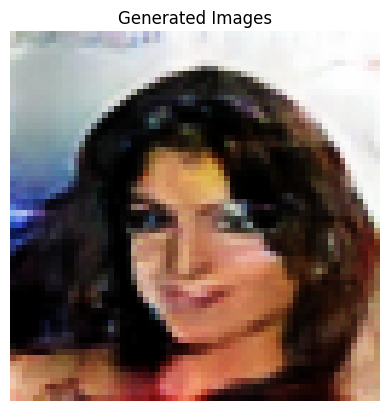

[8/100][550/1000]	Loss_D: 0.4782	Loss_G: 3.1356	D(x): 0.8469	D(G(z)): 0.2382 / 0.0553
[8/100][600/1000]	Loss_D: 0.4497	Loss_G: 3.5555	D(x): 0.8882	D(G(z)): 0.2595 / 0.0377
[8/100][650/1000]	Loss_D: 0.4539	Loss_G: 2.2991	D(x): 0.8681	D(G(z)): 0.2429 / 0.1284
[8/100][700/1000]	Loss_D: 0.4045	Loss_G: 2.6936	D(x): 0.8139	D(G(z)): 0.1612 / 0.0904
[8/100][750/1000]	Loss_D: 0.5152	Loss_G: 1.6098	D(x): 0.6944	D(G(z)): 0.0970 / 0.2383
[8/100][800/1000]	Loss_D: 0.4848	Loss_G: 3.0762	D(x): 0.8997	D(G(z)): 0.2871 / 0.0624
[8/100][850/1000]	Loss_D: 1.0501	Loss_G: 1.0255	D(x): 0.4346	D(G(z)): 0.0631 / 0.4193
[8/100][900/1000]	Loss_D: 0.5671	Loss_G: 1.7199	D(x): 0.7287	D(G(z)): 0.1801 / 0.2208
[8/100][950/1000]	Loss_D: 0.5733	Loss_G: 1.8704	D(x): 0.6455	D(G(z)): 0.0643 / 0.2037
[9/100][0/1000]	Loss_D: 0.5496	Loss_G: 3.3223	D(x): 0.8649	D(G(z)): 0.2949 / 0.0514


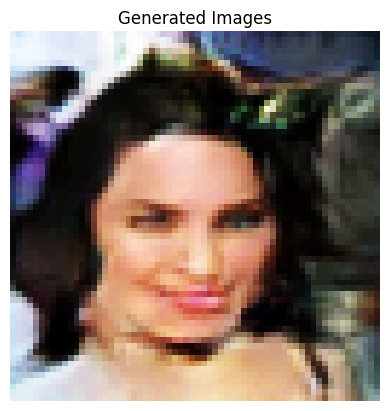

[9/100][50/1000]	Loss_D: 0.4975	Loss_G: 2.2464	D(x): 0.8136	D(G(z)): 0.2199 / 0.1413
[9/100][100/1000]	Loss_D: 0.4980	Loss_G: 4.3162	D(x): 0.9332	D(G(z)): 0.3170 / 0.0183
[9/100][150/1000]	Loss_D: 0.4576	Loss_G: 3.3100	D(x): 0.8909	D(G(z)): 0.2637 / 0.0490
[9/100][200/1000]	Loss_D: 0.4423	Loss_G: 2.1626	D(x): 0.6917	D(G(z)): 0.0380 / 0.1546
[9/100][250/1000]	Loss_D: 0.8541	Loss_G: 0.8136	D(x): 0.5002	D(G(z)): 0.0455 / 0.4878
[9/100][300/1000]	Loss_D: 0.4557	Loss_G: 1.8689	D(x): 0.7574	D(G(z)): 0.1375 / 0.1818
[9/100][350/1000]	Loss_D: 0.4732	Loss_G: 2.6593	D(x): 0.7596	D(G(z)): 0.1342 / 0.0974
[9/100][400/1000]	Loss_D: 0.7490	Loss_G: 1.8397	D(x): 0.6133	D(G(z)): 0.1483 / 0.2057
[9/100][450/1000]	Loss_D: 0.3852	Loss_G: 2.0307	D(x): 0.8088	D(G(z)): 0.1407 / 0.1656
[9/100][500/1000]	Loss_D: 1.5727	Loss_G: 1.4091	D(x): 0.4533	D(G(z)): 0.3056 / 0.3431


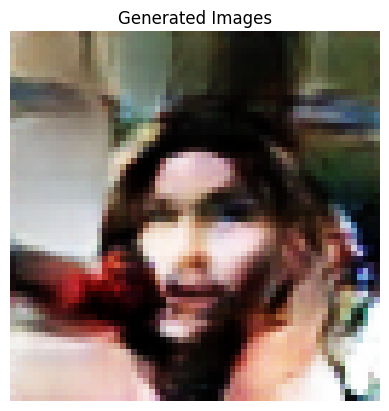

[9/100][550/1000]	Loss_D: 0.3673	Loss_G: 2.7753	D(x): 0.8141	D(G(z)): 0.1280 / 0.0858
[9/100][600/1000]	Loss_D: 0.4663	Loss_G: 3.0211	D(x): 0.8620	D(G(z)): 0.2459 / 0.0646
[9/100][650/1000]	Loss_D: 0.4178	Loss_G: 3.2135	D(x): 0.8759	D(G(z)): 0.2266 / 0.0551
[9/100][700/1000]	Loss_D: 0.5604	Loss_G: 1.8211	D(x): 0.6992	D(G(z)): 0.1279 / 0.1970
[9/100][750/1000]	Loss_D: 0.7037	Loss_G: 1.8736	D(x): 0.5712	D(G(z)): 0.0541 / 0.2092
[9/100][800/1000]	Loss_D: 0.3898	Loss_G: 2.7560	D(x): 0.8561	D(G(z)): 0.1899 / 0.0806
[9/100][850/1000]	Loss_D: 0.3908	Loss_G: 1.8658	D(x): 0.8001	D(G(z)): 0.1254 / 0.1949
[9/100][900/1000]	Loss_D: 0.5110	Loss_G: 2.0070	D(x): 0.7975	D(G(z)): 0.2123 / 0.1803
[9/100][950/1000]	Loss_D: 0.4138	Loss_G: 2.3113	D(x): 0.7825	D(G(z)): 0.1281 / 0.1365
[10/100][0/1000]	Loss_D: 0.5173	Loss_G: 3.5028	D(x): 0.8934	D(G(z)): 0.2989 / 0.0416


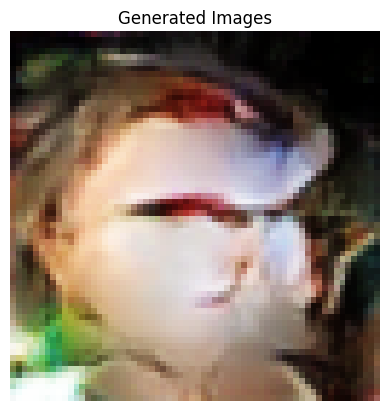

[10/100][50/1000]	Loss_D: 0.9143	Loss_G: 1.1969	D(x): 0.5810	D(G(z)): 0.2180 / 0.3568
[10/100][100/1000]	Loss_D: 0.3915	Loss_G: 2.5754	D(x): 0.7670	D(G(z)): 0.0919 / 0.1063
[10/100][150/1000]	Loss_D: 0.4382	Loss_G: 3.1546	D(x): 0.8718	D(G(z)): 0.2373 / 0.0563
[10/100][200/1000]	Loss_D: 1.6446	Loss_G: 2.9578	D(x): 0.8653	D(G(z)): 0.6641 / 0.1017
[10/100][250/1000]	Loss_D: 0.5015	Loss_G: 1.5050	D(x): 0.6898	D(G(z)): 0.0813 / 0.2661
[10/100][300/1000]	Loss_D: 0.7631	Loss_G: 1.3100	D(x): 0.6324	D(G(z)): 0.1730 / 0.3174
[10/100][350/1000]	Loss_D: 0.9628	Loss_G: 4.8296	D(x): 0.9694	D(G(z)): 0.5508 / 0.0118
[10/100][400/1000]	Loss_D: 0.3382	Loss_G: 2.9763	D(x): 0.9025	D(G(z)): 0.1916 / 0.0671
[10/100][450/1000]	Loss_D: 0.3932	Loss_G: 3.0024	D(x): 0.8814	D(G(z)): 0.2130 / 0.0658
[10/100][500/1000]	Loss_D: 0.2705	Loss_G: 3.4004	D(x): 0.9112	D(G(z)): 0.1461 / 0.0455


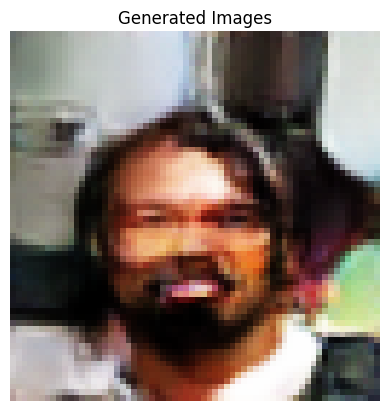

[10/100][550/1000]	Loss_D: 0.5024	Loss_G: 1.4482	D(x): 0.6763	D(G(z)): 0.0511 / 0.2927
[10/100][600/1000]	Loss_D: 0.4532	Loss_G: 2.1222	D(x): 0.7838	D(G(z)): 0.1547 / 0.1573
[10/100][650/1000]	Loss_D: 0.4370	Loss_G: 2.7208	D(x): 0.8271	D(G(z)): 0.1948 / 0.0891
[10/100][700/1000]	Loss_D: 0.4669	Loss_G: 4.2663	D(x): 0.9288	D(G(z)): 0.2948 / 0.0213
[10/100][750/1000]	Loss_D: 0.3687	Loss_G: 3.0918	D(x): 0.8704	D(G(z)): 0.1799 / 0.0637
[10/100][800/1000]	Loss_D: 0.6722	Loss_G: 3.1117	D(x): 0.9000	D(G(z)): 0.3782 / 0.0653
[10/100][850/1000]	Loss_D: 0.4022	Loss_G: 1.5208	D(x): 0.7792	D(G(z)): 0.1101 / 0.2661
[10/100][900/1000]	Loss_D: 0.4550	Loss_G: 1.8195	D(x): 0.7717	D(G(z)): 0.1431 / 0.2039
[10/100][950/1000]	Loss_D: 0.3712	Loss_G: 2.1596	D(x): 0.7521	D(G(z)): 0.0598 / 0.1532
[11/100][0/1000]	Loss_D: 0.6324	Loss_G: 3.2978	D(x): 0.8710	D(G(z)): 0.3350 / 0.0571


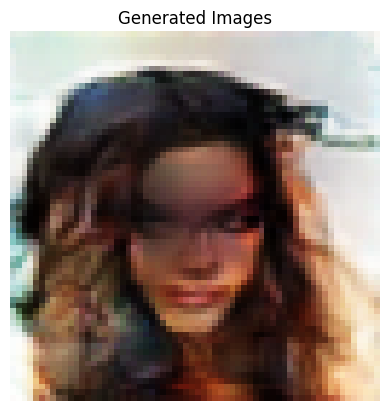

KeyboardInterrupt: 

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

print("Starting Training Loop...")
# For each epoch

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        if i % 500 == 0:
            generate_and_show(netG, latent_dim, num_images=1)

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1